In [1]:
import sys
import time
from dataclasses import dataclass
import random as r
import numpy as np
from functools import partial
from matplotlib import pyplot as plt
from sentencepiece import SentencePieceProcessor
import os; import glob
import requests
from typing import Callable, Sequence, Any
import functools; import operator
from tqdm import tqdm
import pickle

import jax
from jax import (
    Array,
    numpy as jnp,
    random as jrand
)
try:
    from flash_attn_jax import flash_mha
    USE_FLASH_ATT = True
except:
    USE_FLASH_ATT = False
import keras as nn; nn.utils.set_random_seed(42)
nn.mixed_precision.set_dtype_policy("mixed_float16")
import torch

print("Python Version", sys.version); del sys
print(f"Keras Version {nn.__version__} with {nn.backend.backend()} backend \tJax Version {jax.__version__}")
print("Jax backend device", jax.default_backend())
print("PyTorch version:", torch.__version__)

Python Version 3.11.8 (main, Feb 25 2024, 16:39:33) [GCC 11.4.0]
Keras Version 3.0.4 with jax backend 	Jax Version 0.4.23
Jax backend device gpu
PyTorch version: 2.2.1+cpu


# Tokenizer

In [2]:
TOKENIZER_PATH = "sentence_piece_512.model"
spm = SentencePieceProcessor(model_file=TOKENIZER_PATH)
VOCAB_SIZE = spm.vocab_size(); print(VOCAB_SIZE)
SOS = spm.bos_id()
print(spm.Decode(spm.Encode("Hey hi!!!")), spm.Encode("Hey hi!!!"))

512
Hey hi!!! [346, 422, 270, 417, 443, 443, 443]


# Dataset

In [3]:
DATA_CACHE_DIR = "data/TinyStories"
TRAIN_FILE_PATH = os.path.join(DATA_CACHE_DIR, "train.txt")
VAL_FILE_PATH = os.path.join(DATA_CACHE_DIR, "val.txt")

SHARD_DIR = os.path.join(DATA_CACHE_DIR, f"tok{VOCAB_SIZE}")

## File Utils

In [4]:
def download_file(url:str, filename:str, chunk_size:int=1024):
    """Download a file from the given URL and save it with the specified filename"""
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))
    with open(filename, "wb") as file, tqdm(
        desc=filename,
        total=total,
        unit="iB",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

    print(f"{filename} downloaded successfully:")

## Data

In [5]:
def download():
    "download if train file not present and data dir is empty"
    os.makedirs(DATA_CACHE_DIR, exist_ok=True)

    urls = ["https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-train.txt",
            "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-valid.txt"]
    file_paths = [TRAIN_FILE_PATH, VAL_FILE_PATH]

    if (not os.listdir(DATA_CACHE_DIR)):
        # download files
        for url, file_path in zip(urls, file_paths):
            if (not os.path.exists(file_path)):
                download_file(url, file_path)
    else:
        print(f"{file_paths[0]} is present. Skipping download.")

In [6]:
download() # ~8mins to download

data/TinyStories/train.txt is present. Skipping download.


## Pretokenize, Shard and Load Data Functions

In [7]:
def pretokenize_and_save_dataset(train_ds_path:str, val_ds_path:str, num_shards:int):
    if glob.glob(os.path.join(SHARD_DIR, "*.npy")):
        print("Dataset is already pretokenized.")
    else:
        print("Pretokenizing dataset...")
        dataset = open(train_ds_path, "r", encoding="utf-8").read().split("<|endoftext|>")
        val_dataset = open(val_ds_path, "r", encoding="utf-8").read().split("<|endoftext|>")

        dataset = dataset + val_dataset; del val_dataset
        dataset = list(map(str.strip, dataset))
        dataset:list = spm.Encode(
                dataset,
                add_bos=True,
                add_eos=False
            ) # [[SOS story], ..., [SOS story]]
        print("Dataset:")
        print("\tNumber of stories:", len(dataset))

        # flatten
        dataset = functools.reduce(operator.iconcat, dataset, [])
        num_tokens = len(dataset); print("\tNumber of tokens in the dataset:", num_tokens)
        print("\tNumber of unique tokens in the dataset:", len(set(dataset)))
        
        dataset = np.asarray(dataset, dtype=np.uint16) # [SOS story ... SOS story]
        print("\tAvg length of story:", num_tokens/((dataset==SOS).sum()))

        # shard and save dataset
        sharded_datasets_list = np.array_split(dataset, num_shards) # [[SOS story...], [...], [...], ...]
        filenames = [os.path.join(SHARD_DIR, f"shard{i+1}.npy") for i in range(num_shards)]
        
        for filename, sharded_ds in tqdm(zip(filenames, sharded_datasets_list), total=len(filenames), desc="Saving pretokenized shards"):
            with open(filename, "wb") as f:
                np.save(f, sharded_ds)
        print("Done.")


class IterDataset(torch.utils.data.IterableDataset):
    def __init__(self, split:str, maxlen:int, seed:int=42):
        self.split = split
        self.maxlen = maxlen
        
        os.makedirs(SHARD_DIR, exist_ok=True)
        self.shard_filepaths = glob.glob(os.path.join(SHARD_DIR, "*.npy"))
        self.r = r.Random(seed)

    def __iter__(self):
        split_shard_filepaths = self.shard_filepaths[:-1] if self.split == "train" else self.shard_filepaths

        while True:
            self.r.shuffle(split_shard_filepaths)
            for shard in split_shard_filepaths:
                m:np.ndarray = np.load(shard, mmap_mode="r")

                num_batches = len(m)//self.maxlen
                num_batches -= 1 # drop remainder
                assert num_batches > 0, "Number of batches should be greater than 0. Investigate..."

                ixs = list(range(num_batches))
                self.r.shuffle(ixs)

                for ix in ixs:
                    start = ix*self.maxlen
                    end = start + self.maxlen + 1

                    chunk = torch.from_numpy(m[start:end].astype(dtype=np.int64))
                    x = chunk[:-1]
                    y = chunk[1:]
                    yield x, y


class BatchedDataset:
    @staticmethod
    def iter_ds(batch_size, device, num_workers=0, **ds_kwargs):
        ds = torch.utils.data.DataLoader(
            IterDataset(**ds_kwargs), batch_size=batch_size, pin_memory=True,
            num_workers=num_workers
        )

        for x, y in ds:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            yield x, y

# GPT

## Positional Embeddings

In [8]:
class PositionalEmbedding:
    """```
    Sinusoidal Fixed Positional Embeddings
    Args:
        maxlen:int
        dim:int
    sinusoidal_embeddings: 
        pos_emb: (1, maxlen, dim)
    get_freqs:
        get_freqs: sin_freqs(1, maxlen, 1, dim), cos_freqs(1, maxlen, 1, dim)
    ```"""
    def __init__(self, maxlen:int, dim:int):
        p, i = jnp.meshgrid(jnp.arange(float(maxlen)), jnp.arange(dim/2)*2)
        theta = (p/1e4**(i/dim)).T
    
        self.pos_emb = jnp.stack([jnp.sin(theta), jnp.cos(theta)], axis=-1)
        self.pos_emb = self.pos_emb.reshape((maxlen, dim))[None] # (1, maxlen, dim)
    
    def sinusoidal_embeddings(self):
        return self.pos_emb # (1, maxlen, dim)
    
    def get_freqs(self):
        sin_freqs = self.pos_emb[..., None, ::2].repeat(2, axis=-1)
        cos_freqs = self.pos_emb[..., None, 1::2].repeat(2, axis=-1)
        return sin_freqs, cos_freqs # (1, maxlen, 1, dim), (1, maxlen, 1, dim)

## Attention

In [9]:
class Attention(nn.Layer):
    """```
    Multi-head Attention
    Args:
        causal:bool
        config
    Input:
        x: shape(B, N, d_model)
        training: bool
    Output:
        linear_att_out: shape(B, N, d_model)
    ```"""
    def __init__(
            self,
            causal:bool,
            config,
            **kwargs
    ):
        super().__init__(**kwargs)
        assert config.d_model % config.num_heads == 0
        self.flash = config.use_flash_att
        self.causal = causal
        self.num_heads = config.num_heads
        self.dim = config.d_model//config.num_heads

        self.wq = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.wk = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.wv = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.dropout = nn.layers.Dropout(config.dropout_rate)

        self.wo = nn.layers.Dense(
            config.d_model,
            use_bias=config.use_bias,
            kernel_initializer=config.intializer(std=0.02/(2*config.num_layers)**0.5)
        )
        if causal and (not config.use_flash_att): # when causal and not using flash att
            self.causal_mask = jnp.triu(jnp.full(shape=(1, 1, config.maxlen, config.maxlen), fill_value=-jnp.inf), k=1)

    def call(
            self,
            x:Array, # (B, T, d_model)
            training:bool
    ):
        B, T, d_model = x.shape

        # compute q, k, v
        q = self.wq(x) # (B, T, d_model)
        k = self.wk(x) # (B, T, d_model)
        v = self.wv(x) # (B, T, d_model)
        
        # compute attention weights
        if self.flash:
            shape = (B, T, self.num_heads, self.dim)
            q, k, v = q.reshape(shape), k.reshape(shape), v.reshape(shape) # (B, T, h, dim)
            att_out = flash_mha(q, k, v, softmax_scale=None, is_causal=self.causal) # (B, T, h, dim)
        else:
            shape = (B, self.num_heads, T, self.dim)
            q, k, v = q.reshape(shape), k.reshape(shape), v.reshape(shape) # (B, h, T, dim)
            att_wei = (q @ jnp.matrix_transpose(k))/self.dim**0.5 # (B, h, T, T) <= (B, h, T, dim) @ (B, h, T, dim).transpose(2, 3)
            # causal mask
            if self.causal:
                att_wei += self.causal_mask[:, :, :T, :T] # (B, h, T, T)
            att_wei = jax.nn.softmax(att_wei, axis=-1) # (B, h, T, T)
            # apply attention weights to v
            att_out = att_wei @ v # (B, h, T, T) @ (B, h, T, dv) => (B, h, T, dv)

        # combine heads
        att_out = att_out.reshape((B, T, d_model)) # (B, T, h*dim) ==> (B, T, d_model)

        # linear of att_out
        linear_att_out = self.wo(att_out)
        linear_att_out = self.dropout(linear_att_out, training=training) # (B, T, d_model)
        return linear_att_out

## Block

In [10]:
class TransformerBlock(nn.Model):
    """```
    TransformerBlock
    Args:
        causal:bool
        config
    Inputs: 
        inputs: shape(B, T, d_model)
        pad_mask: shape(B, T) of boolean dtype
    Outputs:
        outputs: shape(B, T, d_model)
    ```"""
    def __init__(
            self, 
            causal:bool, 
            config,
            **kwargs
    ):
        super().__init__(**kwargs)
        dff_in = 4*config.d_model
        self.norm1 = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        self.mha = Attention(causal, config)

        self.ffn = nn.Sequential([
            nn.layers.Dense(int(dff_in), use_bias=config.use_bias, kernel_initializer=config.intializer(std=0.02)),
            nn.layers.Activation(lambda x: nn.activations.gelu(x, approximate=True)),
            nn.layers.Dense(config.d_model, use_bias=config.use_bias, kernel_initializer=config.intializer(std=0.02)),
            nn.layers.Dropout(config.dropout_rate)
        ])
        self.norm2 = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        
    def call(self, x:Array, training:bool):
        z = x + self.mha(self.norm1(x), training=training)
        y = z + self.ffn(self.norm2(z), training=training)
        return y # (B, T, d_model)

In [11]:
def build_model(model:nn.Model, input_shape:tuple, val_intervals:tuple):
    blabla = model(
        jrand.randint(jrand.PRNGKey(32344), shape=input_shape, minval=val_intervals[0], maxval=val_intervals[-1]), training=True
    ); del blabla
    return model

class TieWeights(nn.Layer):
    def __init__(self, Layer:nn.Layer, bias_units:int|None, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.Layer = Layer # weights of (1, vocab_size, d_model)
        self.use_bias = bool(bias_units)
        self.activation = nn.layers.Activation(nn.activations.get(activation), dtype=kwargs["dtype"])
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(bias_units,), initializer="zeros", trainable=True)
        
    def call(self, x): # (B, T, d_model)
        W = jnp.array(self.Layer.weights)[0] # (vocab_size, d_model)
        z = x @ jnp.matrix_transpose(W) # (B, T, vocab_size)
        if self.use_bias:
            z += self.bias
        return self.activation(z)

## Transformer

In [12]:
class Transformer(nn.Model):
    """```
    Decoder Transformer!!
    Args:
        causal:bool
        config:
            d_model: int
            num_heads: int
            num_layers: int
            maxlen: int
            vocab_size: int
            output_units: int => if None is equal to vocab_size
            use_bias:bool,
            dropout_rate: float
        output_activation:str
    Inputs:
        inputs: shape(B, T)
    Outputs: 
        outputs: shape(B, T, d_model)    
    ```"""
    def __init__(self, causal:bool, config, output_activation:str=None, **kwargs):
        super().__init__(**kwargs)
        if config.output_units is None:
            config.output_units = config.vocab_size
        # pos embedding
        self.pos_embed = PositionalEmbedding(config.maxlen, config.d_model).sinusoidal_embeddings() # (1, maxlen, d_model)
        # embedding tokens and dropout
        self.emb_dropout = nn.layers.Dropout(config.dropout_rate)
        self.token_embed = nn.layers.Embedding(
            config.vocab_size, 
            config.d_model,
            embeddings_initializer=config.intializer(std=0.02)
        )

        # block layers
        self.block_layers = [
                TransformerBlock(
                    causal=causal, 
                    config=config
                ) for _ in range(config.num_layers)
            ]

        # final layer: outputs logits with dropout
        self.norm = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        
        self.linear = TieWeights(
            self.token_embed,
            bias_units=None if config.use_bias is False else config.output_units,
            activation=output_activation,
            dtype="float32"
        )

    def call(
            self, 
            inputs:Array,
            training=False
    ):
        # embed tokens
        x = self.emb_dropout(
            self.token_embed(inputs)+self.pos_embed[:, :inputs.shape[-1], :], training=training
        ) # (B, T) ==> (B, T, d_model) # (B, T) ==> (B, T, d_model)
        
        # block layers
        for layer in self.block_layers:
            x = layer(x, training=training) # (B, T, d_model) ==> (B, T, d_model)
        x = self.norm(x)

        # linear layer: outputs logits
        logits = self.linear(x) # (B, T, d_model) ==> (B, T, vocab_size)
        return logits

# GPT Configuration

In [13]:
@dataclass
class GPTConfig:
    """GPT 280K Configuration"""
    use_flash_att:bool=USE_FLASH_ATT
    d_model:int = 64
    num_layers:int = 5
    num_heads:int = 8
    maxlen:int = 512
    vocab_size:int = VOCAB_SIZE
    output_units:int = None
    assert d_model % 2 == 0
    assert d_model % num_heads == 0
    dropout_rate:float = 0.0
    use_bias:bool = True
    intializer:Callable = lambda std: nn.initializers.RandomNormal(mean=0.0, stddev=std)

GPTConfig()

GPTConfig(use_flash_att=True, d_model=64, num_layers=5, num_heads=8, maxlen=512, vocab_size=512, output_units=None, dropout_rate=0.0, use_bias=True, intializer=<function GPTConfig.<lambda> at 0x7c8b558904a0>)

# Loss vs Learning Rate

```python
def LossvsLR(): # (B, maxlen)
    model = build_model(
        Transformer(causal=True, config=GPTArgs), 
        (2, GPTArgs.max_context_length), 
        (0, GPTArgs.vocab_size-1)
        )
    inputs = jrand.randint(jrand.PRNGKey(32344), shape=(2, GPTArgs.max_context_length+1), minval=0, maxval=GPTArgs.vocab_size-1)

    def get_loss(lr, model, inputs):
        x, y = inputs[:, :-1], inputs[:, 1:]
        model.compile(
            optimizer=nn.optimizers.AdamW(
                learning_rate=lr, beta_1=0.9, beta_2=0.95, clipvalue=1e0, weight_decay=1e-1),
            loss=nn.losses.SparseCategoricalCrossentropy(from_logits=True)
        )
        loss = model.train_on_batch(x=x, y=y)
        return loss.tolist()
    
    lrs = (10**jnp.linspace(-6, -2, 100)).tolist()
    losses = [get_loss(lr, model, inputs) for lr in lrs]
    # losses = jax.vmap(get_loss, in_axes=(None, 0))(model, lrs)
    return lrs, losses
```

# Training Arguments

In [63]:
@dataclass
class TArgs:
    # lr scheduler
    max_lr:float = 1e-3
    decay_rate:float = 0.1
    num_steps:int = 100_000

    # optimizer
    beta1:float = 0.9
    ## don't use default 0.999, loss doesn't improve after a short ammount of time
    ## using 0.99 loss starts to increase after a while. See https://github.com/keras-team/keras/issues/7603#issuecomment-321851648
    beta2:float = 0.9759
    weight_decay:float = 1e-4
    clipnorm:float = 1e0
    num_grad_accumalation_steps:int = 1
    ## num_tok_per_update = batch_size * maxlen * gradient_accumalation = 128 * 256 * 1 = 32_768

    # training
    checkpoint_dir:str = "weights/stories512"
    eval_freq:int = 2000
    eval_steps:int = 100
    batch_size:int = 128 # mini-batch_size if num_grad_accumalation_steps > 1
    ## early stopping with restore best weights, keeping it very high to see if training improves latter
    patience:int = 15

TArgs()

TArgs(max_lr=0.001, decay_rate=0.1, num_steps=100000, beta1=0.9, beta2=0.9759, weight_decay=0.0001, clipnorm=1.0, num_grad_accumalation_steps=1, checkpoint_dir='weights/stories512', eval_freq=2000, eval_steps=100, batch_size=128, patience=15)

# Model

In [15]:
model = Transformer(causal=True, config=GPTConfig, output_activation=None)
model = build_model(model, (2, GPTConfig.maxlen), (0, GPTConfig.vocab_size-1))
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ embedding (Embedding)           │ ?                         │     32,768 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block               │ ?                         │     49,792 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_1             │ ?                         │     49,792 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_2             │ ?                         │     49,792 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_3             │ ?                         │     49,792 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_4             │ ?                         │     49,792 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ layer_normalization_10          │ ?                         │        128 │
│ (LayerNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ tie_weights (TieWeights)        │ ?                         │     33,280 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 282,368 (1.08 MB)

 Trainable params: 282,368 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

# Load data

In [16]:
pretokenize_and_save_dataset(TRAIN_FILE_PATH, VAL_FILE_PATH, num_shards=50)

ds_iterater = partial(
    BatchedDataset.iter_ds,
    batch_size=TArgs.batch_size,
    device="cpu",
    num_workers=0,
    maxlen=GPTConfig.maxlen,
    seed=42
)
train_iterator, val_iterator = (
    ds_iterater(split="train"),
    ds_iterater(split="val")
)

Dataset is already pretokenized.


# Lr schedule

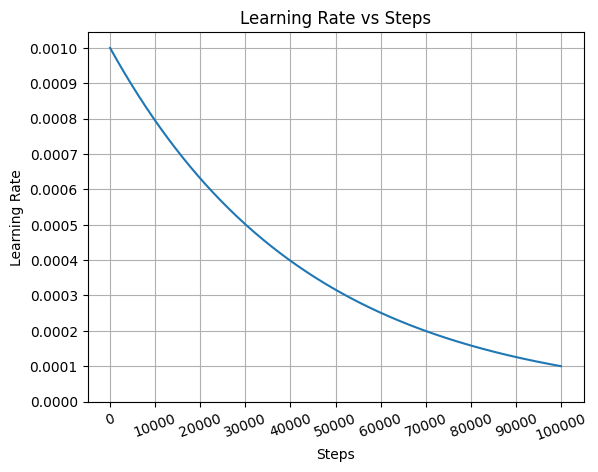

In [17]:
learning_rate = nn.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=TArgs.max_lr,
    decay_rate=TArgs.decay_rate,
    decay_steps=TArgs.num_steps,
)

steps = jnp.arange(1, TArgs.num_steps+1)
lrs = jax.vmap(learning_rate)(steps)

plt.plot(steps, lrs)
plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Steps")
plt.xticks(range(0, TArgs.num_steps+10_000, 10_000), rotation=20)
plt.yticks(jnp.arange(0, TArgs.max_lr+1e-4, 1e-4).tolist())
plt.show()

# Save and Load model

In [18]:
def save_object(dir_suffix_ftype:str, obj:Any):
    """
    dir_suffix_ftype: directory suffix and file type separated by "|"
    obj: Anything which is to be stored
    """
    dir, suffix, ftype = dir_suffix_ftype.split("|"); path = os.path.join(dir, "".join([suffix, f".{ftype}"]))
    os.makedirs(name=dir, exist_ok=True)
    with open(path, "wb") as file:
        pickle.dump(obj=obj, file=file, protocol=pickle.HIGHEST_PROTOCOL)
    return path

In [19]:
def load_object(path:str):
    with open(path, "rb") as file:
        obj = pickle.load(file)
    return obj

# Training

In [20]:
optimizer = nn.optimizers.LossScaleOptimizer(
    nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=TArgs.beta1,
        beta_2=TArgs.beta2,
        clipnorm=TArgs.clipnorm,
        weight_decay=TArgs.weight_decay
    )
)
loss_fn = nn.losses.SparseCategoricalCrossentropy(from_logits=True)

@jax.jit
def get_accuracy(y_true:Array, logits:Array): # (B, T, vocab_size), (B, T)
    batched_num_correct = (logits.argmax(-1)==y_true).sum(-1)/y_true.shape[-1] # (B,)
    accuracy = batched_num_correct.mean()
    return accuracy

@partial(jax.jit, static_argnums=-1)
def compute_loss(trainable_variables:list, non_trainable_variables:list, X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    logits, non_trainable_variables = model.stateless_call(
        trainable_variables,  non_trainable_variables,
        X_batch
    )
    loss = loss_fn(y_batch, logits)
    accuracy = get_accuracy(y_batch, logits)
    unscaled_loss = loss/num_grad_accumalation_steps
    scaled_loss = optimizer.scale_loss(unscaled_loss)
    return scaled_loss, (unscaled_loss, accuracy, non_trainable_variables)
grad_fn = jax.value_and_grad(compute_loss, has_aux=True)

@partial(jax.jit, static_argnums=-1)
def mini_step(train_state:Sequence[list], X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    trainable_variables, non_trainable_variables = train_state

    (_, aux), scaled_grad = grad_fn(
        trainable_variables, non_trainable_variables, X_batch, y_batch,
        num_grad_accumalation_steps
    )
    (unscaled_loss, accuracy, non_trainable_variables) = aux
    return scaled_grad, (unscaled_loss, accuracy), (trainable_variables, non_trainable_variables)

@jax.jit
def update_params(grads:list, trainable_variables:list, optimizer_variables:list):
    trainable_variables, optimizer_variables = optimizer.stateless_apply( # also handles scaled grads if LossScalerOPtimizer is used
        optimizer_variables, grads, trainable_variables
    ) # returns updated trainable_variables
    return trainable_variables, optimizer_variables

def evaluate(train_state:Sequence[list]):
    trainable_variables, non_trainable_variables = train_state
    mean_losses = []; mean_accuracies = []
    for eval_batch_iter in [train_iterator, val_iterator]:
        X_batch, y_batch = next(eval_batch_iter)
        losses = jnp.empty(TArgs.eval_steps)
        accuracies = jnp.empty_like(losses)

        for eval_step in range(TArgs.eval_steps):
            _, (unscaled_loss, accuracy, non_trainable_variables) = compute_loss(
                trainable_variables, non_trainable_variables,
                jnp.array(X_batch), jnp.array(y_batch), 1
            )
            losses = losses.at[eval_step].set(unscaled_loss)
            accuracies = accuracies.at[eval_step].set(accuracy)
            X_batch, y_batch = next(eval_batch_iter)
        mean_losses.append(losses.mean())
        mean_accuracies.append(accuracies.mean())
    return mean_losses, mean_accuracies # ([train_loss, val_loss], [train_accuracy, val_accuracy])

In [21]:
def train(return_best_states:bool):
    step = 1; wait = 0
    training_losses = {"train": []}

    trainable_variables = model.trainable_variables; optimizer.build(trainable_variables)
    non_trainable_variables = model.non_trainable_variables
    optimizer_variables = optimizer.variables

    best_step = 1
    best_train_state = (trainable_variables, non_trainable_variables)
    best_val_loss = 1e8

    t0 = time.time()
    print("Training about to start...")
    X_batch, y_batch = next(train_iterator)
    while True:
        # condition to terminate
        if step > TArgs.num_steps or wait > TArgs.patience:
            print(f"Early Stopping at Step {step}." if wait > TArgs.patience else "Training Terminated.")
            break

        # train model
        grads = jax.tree_util.tree_map(jnp.zeros_like, trainable_variables)
        for _ in range(TArgs.num_grad_accumalation_steps):
            grad, (loss, accuracy), (trainable_variables, non_trainable_variables) = mini_step(
                (trainable_variables, non_trainable_variables), 
                jnp.array(X_batch), jnp.array(y_batch),
                TArgs.num_grad_accumalation_steps
            )
            grads = jax.tree_util.tree_map(
                lambda g1, g2: jnp.add(g1, g2), grads, jax.tree_util.tree_map(jnp.asarray, grad)
            ) # sum grads for grad accumation
            X_batch, y_batch = next(train_iterator)
        grad = None # save memory

        loss = loss*TArgs.num_grad_accumalation_steps # loss from last mini-step

        trainable_variables, optimizer_variables = update_params(
            grads, trainable_variables, optimizer_variables
        )
        grads = None # save memory

        if step % TArgs.eval_freq == 0 or step == TArgs.num_steps:
            print("Estimating Losses...")
            mean_losses, mean_accuracies = evaluate((trainable_variables, non_trainable_variables))
            print(
                f"\t| Training Loss: {mean_losses[0]:.4f} || Training Accuracy: {mean_accuracies[0]:.4f} |" 
                f"| Validation Loss: {mean_losses[1]:.4f} || Validation Accuracy: {mean_accuracies[1]:.4f} |"
            )
            
            _ = save_object(
                TArgs.checkpoint_dir+f"|trstate{step}|weights",
                obj=best_train_state
            )
            print(f"Saved weights of step {step}.")

            if mean_losses[1] < best_val_loss:
                best_val_loss = mean_losses[1]
                best_train_state = (trainable_variables, non_trainable_variables)
                best_step = step
                wait = 0
            else:
                wait += 1
        
        # time
        t1 = time.time()
        dt = t1-t0; t0 = t1

        # print the essentials
        print(
            f"| Step: {step} || Loss: {loss:.4f} || Accuracy: {accuracy:.4f} |"
            f"| LR: {learning_rate(step):e} || dt: {dt*1000:.2f}ms |"
        )
        training_losses["train"].append(loss.tolist())
        step += 1
    
    if return_best_states:
        print(f"Best Weights are from Step {best_step}")
        print("With an Estimated Validation Loss of", best_val_loss)
        return best_train_state, training_losses

    return (trainable_variables, non_trainable_variables), training_losses

In [ ]:
best_train_state, losses = train(return_best_states=True)
# clear outputs as it's very long

```python
Training Terminated.
Best Weights are from Step 76000
With an Estimated Validation Loss of 1.3343884
```

In [23]:
_ = save_object(
        TArgs.checkpoint_dir+f"|trstate|weights",
        obj=best_train_state
    )

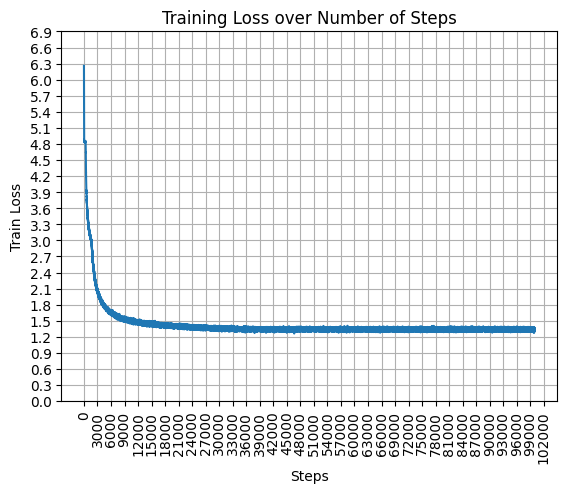

In [24]:
plt.plot(losses["train"])
plt.title("Training Loss over Number of Steps")
plt.xlabel("Steps")
plt.ylabel("Train Loss")
plt.yticks(jnp.arange(0, 7, 0.3).tolist())
plt.xticks(range(0, TArgs.num_steps+3_000, 3_000), rotation=90)
plt.grid(True)
plt.show()

### When beta_2 (momentum was 0.99)
* Loss starts to increase after 50k steps due to high momentum, changing it to 0.9759 solved the problem and got a bit better result

    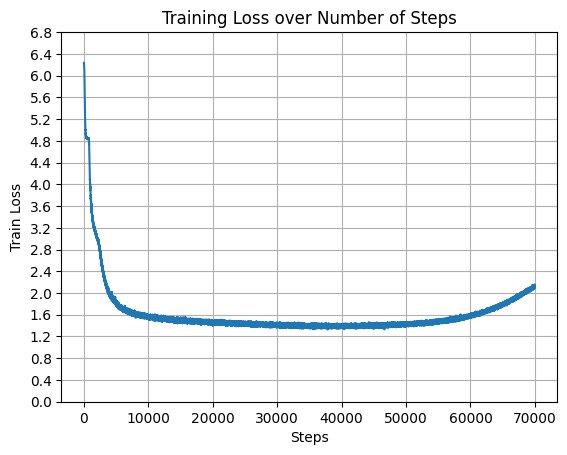

# Sampling from model

In [25]:
class GenerateTokens:
    def __init__(self, model:nn.Model, train_state:Sequence[list], maxlen:int, sos:int):
        self.SOS = jnp.array([[sos]])
        self.model = model
        self.train_state = train_state
        self.maxlen = maxlen
    
    @staticmethod
    @jax.jit
    def randCategorical(key:Array, logits:Array):
        idx_next = jrand.categorical(key, logits)[..., None]
        return idx_next # (1, 1)

    @staticmethod
    # TODO(VachanVY): Debug when jitted; does it speed up code?
    # @partial(jax.jit, static_argnums=-1)
    def topK(key:Array, logits:Array, k:Array):
        if jnp.where(k==1, True, False):
            idx_next = logits.argmax(-1, keepdims=True)
            return idx_next
        logits, topK_idx = jax.lax.top_k(logits, k=k)
        idx = jrand.categorical(key, logits)
        idx_next = topK_idx[0][idx][..., None]
        return idx_next # (1, 1)

    @staticmethod
    # TODO(VachanVY): Debug when jitted; does it speed up code?
    # @partial(jax.jit, static_argnums=(-1, -2))
    def topP(key:Array, logits:Array, p:float, k:int|None=None):
        probs = jax.nn.softmax(logits, axis=-1)
        # reverse arg sort of probs
        rev_argsort_prob_idx = jnp.argsort(probs)[:, ::-1]
        # True bools of idx less than p that sum less than p || False bool of least idxs that sum more than p
        less_than_p_bools = (jnp.cumsum(probs.take(rev_argsort_prob_idx), axis=-1) <= p)

        # idx from which to mask
        mask_from_id = less_than_p_bools.sum()+1
        # idxs to mask
        mask_idx = rev_argsort_prob_idx[:, mask_from_id:]
        # -inf masked idx won't be sampled 
        logits = logits.at[:, mask_idx].set(-jnp.inf)

        if k is not None:
            key, _ = jrand.split(key)
            idx_next = GenerateTokens.topK(key, logits, k)
            return idx_next # (1, 1)
        
        idx_next = jrand.categorical(key, logits)[..., None]
        return idx_next # (1, 1)

    @partial(jax.jit, static_argnums=0)
    def get_logits(self, idx_cond:Array, trainable_variables:list, non_trainable_variables:list):
        logits, non_trainable_variables = self.model.stateless_call(
            trainable_variables, non_trainable_variables, idx_cond
        )
        return logits[:, -1, :], non_trainable_variables

    def generate(self, idx:Array, max_tok:int=500, top_k:int|None=None, top_p:float|None=None,  temp:float=0.8, seed:int=42):
        trainable_variables, non_trainable_variables = self.train_state
        if (not top_k) and (not top_p):
            sampleTok = GenerateTokens.randCategorical
        elif (top_k is not None) and (top_p is not None):
            sampleTok = lambda key, logits: GenerateTokens.topP(key, logits, top_p, top_k)
        elif top_k is not None:
            sampleTok = lambda key, logits: GenerateTokens.topK(key, logits, top_k)
        elif top_p is not None:
            sampleTok = lambda key, logits: GenerateTokens.topP(key, logits, top_p)
        else:
            assert False, "(?_?) ¯\(°_o)/¯"
        
        key = jrand.PRNGKey(seed)
        for _ in range(max_tok):
            idx_cond = idx[:, -self.maxlen:] # (B=1, T)
            logits, non_trainable_variables = self.get_logits(
                idx_cond, trainable_variables, non_trainable_variables
            ) # (B, vocab_size)
            idx_next = sampleTok(key, logits/temp) # (1, 1)
            if idx_next == self.SOS:
                break
            key, _ = jrand.split(key)
            idx = jnp.concatenate((idx, idx_next), axis=-1) # (B=1, T+1)
        return idx[0].tolist()

sampler = GenerateTokens(model, best_train_state, GPTConfig.maxlen, sos=SOS)

In [26]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Once upon a time,")]), top_k=1)))

Once upon a time, there was a little boy named Tim. Tim loved to play with his toy car. One day, he saw a big box in his yard. The box was very fast. Tim wanted to play with the box.
Tim asked his friend, Sam, "Can I play with the box?" Sam said, "Yes, I can play with the box." Sam said, "Yes, I can play with my box."
Tim and Sam played with the box together. They played together all day. They had so much fun. Then, they found a big box. Tim and Sam were very happy. They played together all day.


In [54]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Lily and Ben")]), top_p=0.9)))

Lily and Ben were playing with their toys in the mirror. They were very clear and liked to play with their toys and learn. Lily was a massy, so she shouted to her friends, Sam. Sam put on her pocket and colorful caves and colorful wings. They called for their toys and them to play together.
Lily and Ben went back home and clear. They went to their home and decided to play with their toys. They laughed and laughed. They were happy again. They both learned that are not special things. They played with their toys and always learned to be careful. They were very happy and licked their ear.


In [28]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]]), top_p=0.9, seed=343434)))

Once upon a time, there was a little girl named Lily. She was very curious. She loved to play with her toys and the bridge. Every day, she would see her toys and make things that were many friends.
One day, Lily's mom came to play with her toys and said, "No, you can't touch the cake!" The bridge was sad, but she still wanted to play with her toys. She knew she had to be careful with her mom and dad.
They kept her doll very much. Then, they saw something good. Lily's mom was so curious and gave her a big hug. All the kids were so pretty and shared. And from that day on, Lily was not shy anymore.


In [29]:
print(spm.Decode(
    sampler.generate(
        idx=jnp.array(
            [[SOS]+spm.Encode(
    "Once upon a time there was a little girl named Lucy. She loved to go to the store to buy sweets with her mom and dad"
                )]
            ), 
            seed=13213, top_k=1
            )
        )
)

Once upon a time there was a little girl named Lucy. She loved to go to the store to buy sweets with her mom and dad. One day, Lucy's mommy and her mommy went to the store.
At the store, Lucy's mommy and daddy came to the store. Lucy was very happy and said, "Thank you, Lucy!" Her mommy said, "You're welcome, Lucy."
Lucy and her mommy went to the store. They saw a big, red ball. Lucy was very happy and said, "Thank you, Lucy!" And they all lived happily ever after.


In [30]:
ids = sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Once upon a time, there was a king")]), top_k=1)
print(spm.Decode(ids[0].tolist()))

Once upon a time, there was a king. The king was very compassionate. He liked to play with his friends. One day, he saw a big tree with a big tree. The tree was very fast.
The king and the king a lot. The king was very happy. The king was very happy. The king and the king all played together. They were happy.
The king and the king a lot of fun. They were happy. The king and the king went home. They played together all day. The king was happy to see the king.


In [61]:
ids = sampler.generate(idx=jnp.array([[SOS]+spm.Encode(
    "Once upon a time, in a big forest, there was a fearful little dog named Spot")]), top_k=2)
print(spm.Decode(ids[0].tolist()))

Once upon a time, in a big forest, there was a fearful little dog named Spot. Spot loved to play in the water. One day, he went to the park to play.
As Spot was walking, he saw a big tree. He saw a big tree with many jewels. The tree was very happy. He wanted to play with the jewels in the tree.
Spot saw the tree and wanted to play with it. He asked the jewel, "Can I play too?" The jewelry was happy and said, "Yes, I can play with you." The jewelry began to shake the jewels. Spot was very happy.
As the jewels were playing, the jewels were shared the tree. They all became friends. They played together every day. And from that day on, Spot and the jewels were best friends.


In [32]:
ids = sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Once upon a time,")]), top_k=2)
print(spm.Decode(ids[0].tolist()))

Once upon a time, in a small house, there lived a little girl named Amy. She loved to play with her friends. One day, she went to the park with her mom and dad to play with her toys in the park.
At the park, Amy's friend, a little boy named Tim, saw the boy. They were shy and colorful. They played together all day long, and had a fun day at the park.
Amy and Amy played with their toys and had a lot of fun. They had so much fun playing together. Amy was very happy and played with her toys all day long. They had a lot of fun together. And they all lived happily ever after.


# (?_?)

```python
eval_losses = {"train": [], "val":[]}

@partial(jax.jit, static_argnums=(0, 1))
def eval_step(model:nn.Model, loss_fn:nn.Loss, X_batch:Array, y_batch:Array):
    logits = model(X_batch, training=False)
    loss = loss_fn(y_batch, logits)
    return loss

class EvaluateModel(nn.callbacks.Callback):
    def __init__(self, patience):
        super().__init__()
        self.patience = patience
        self.best_val_loss = jnp.inf
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        losses = {"train": [], "val":[]}; print("\n")
        for split in ["val", "train"]:
            for X_batch, y_batch in datasets[split].shuffle(132313, reshuffle_each_iteration=True).take(TArgs.eval_steps).as_numpy_iterator():
                loss = eval_step(model, loss_fn, jnp.array(X_batch), jnp.array(y_batch))
                losses[split].append(loss.tolist())

            eval_losses[split].append(sum(losses[split])/len(losses[split]))
            print(f"\t{split} loss: {eval_losses[split][-1]}")

        latest_val_loss = eval_losses["val"][-1]
        if latest_val_loss < self.best_val_loss:
            self.best_val_loss = latest_val_loss
            self.best_weights = model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Early stopping after {epoch} epochs. Restoring best weights")
                model.stop_training = True
                model.set_weights(self.best_weights)

evaluate_model = EvaluateModel(patience=TArgs.patience)
```

```python
flatten_list = lambda dataset: functools.reduce(operator.iconcat, dataset, [])

def pretokenize_and_save_dataset(ds_path:str, save_dir:str, num_shards:int):
    # load dataset
    dataset = open(ds_path, "r", encoding="utf-8").read() # [...]
    dataset = dataset.split("<|endoftext|>")
    dataset:list = spm.Encode(
            tf.strings.strip(dataset).numpy().tolist(), 
            add_bos=True,
            add_eos=False
        ) # [[SOS story], ..., [SOS story]]
    num_stories = len(dataset)
    print("Dataset:")

    # Flatten list
    dataset = flatten_list(dataset) # [SOS story ... SOS story]
    num_tokens = len(dataset)
    print("\tNumber of stories in the Dataset:", num_stories)
    print("\tNumber of tokens:", num_tokens)
    print("\tNumber of unique tokens:", len(set(dataset)))
    dataset = np.asarray(dataset, dtype=np.uint16)
    print("\tAvg length of story:", num_tokens/((dataset==1).sum()))

    # shard and save dataset
    sharded_datasets_list = np.array_split(dataset, num_shards) # [[SOS story...], [...], [...], ...]
    filenames = [f"{save_dir}shard{i+1}.npy" for i in range(num_shards)]

    for filename, sharded_ds in zip(filenames, sharded_datasets_list):
        with open(filename, "wb") as f:
            np.save(f, sharded_ds)
    return filenames

class DataGen:
    def __init__(self, maxlen:int, batch_size:int, num_shards:int, shard_dir:str, data_path:str|None=None):
        self.maxlen = maxlen
        self.batch_size = batch_size
        if os.path.exists(shard_dir) and os.listdir(shard_dir) :
            filenames = glob.glob(os.path.join(shard_dir, "*.npy"))
        else:
            assert data_path is not None, f"\t{shard_dir} doesn't exist, input the data_path to pretokenize and save"
            os.makedirs(shard_dir)
            filenames = pretokenize_and_save_dataset(data_path, shard_dir, num_shards)
        r.shuffle(filenames)
        num_train_files = round(0.9651*num_shards)
        print(f"\tNumber of files taken for training: {num_train_files}/{num_shards}")
        self.sharded_filenames = {"train":filenames[:num_train_files], "val":filenames[num_train_files:]}
    
    def generate_sequences(self, split):
        r.shuffle(self.sharded_filenames[split])
        for filename in self.sharded_filenames[split]:
            memmaped = np.lib.format.open_memmap(filename, dtype=np.uint16, mode="r")
            batch_idx = list(range(len(memmaped)//self.maxlen))
            r.shuffle(batch_idx)

            for batch in batch_idx:
                start = batch * self.maxlen
                end = start + self.maxlen + 1
                seq = tf.constant(memmaped.astype(np.int32))[start:end]
                yield seq[:-1], seq[1:]
    
    def get_datasets(self):
        train_ds = tf.data.Dataset.from_generator(
            lambda: self.generate_sequences("train"),
            output_signature=(
                tf.TensorSpec(shape=(self.maxlen,), dtype=tf.int32),
                tf.TensorSpec(shape=(self.maxlen,), dtype=tf.int32)
            )
        ).batch(
            self.batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE
        ).repeat().prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_generator(
            lambda: self.generate_sequences("val"),
            output_signature=(
                tf.TensorSpec(shape=(self.maxlen,), dtype=tf.int32),
                tf.TensorSpec(shape=(self.maxlen,), dtype=tf.int32)
            )
        ).batch(
            self.batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE
        ).prefetch(tf.data.AUTOTUNE)
        datasets = {"train":train_ds, "val":val_ds}
        return datasets

datagen = DataGen(
    maxlen=GPTArgs.max_context_length, 
    batch_size=TArgs.batch_size,
    num_shards=DataArgs.num_shards,
    shard_dir=DataArgs.shards_path, 
    data_path=DataArgs.all_ds_path
)

datasets = datagen.get_datasets() #~1.65mins with the tokenization
datasets
```

```python
def load_data_as_tfds(
    dataset:np.ndarray,
    batch_size:int,
    maxlen:int,
    shift:int,
):
    # [SOS story ... SOS story]
    dataset = tf.data.Dataset.from_tensor_slices(dataset.tolist())
    dataset = dataset.window(maxlen+1, shift=shift, drop_remainder=True)
    # [[...], [...], [...], ...] shape(m, maxlen+1)
    dataset = dataset.flat_map(lambda window: window.batch(maxlen+1))
    dataset = dataset.batch(batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).shuffle(batch_size)
    dataset = dataset.map(lambda window: (window[:, :-1], window[:, 1:]), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def load_data(
    dataset_path:str,
    batch_size:int,
    maxlen:int,
    shift:int,
    num_shards:int,
    shard_dir:str
):
    if os.path.exists(shard_dir) and os.listdir(shard_dir):
        filenames = glob.glob(os.path.join(shard_dir, "*.npy"))
    else:
        os.makedirs(shard_dir)
        filenames = pretokenize_and_save_dataset(dataset_path, num_shards=num_shards, shard_dir=shard_dir)
    r.shuffle(filenames)
    to_tfds = lambda dataset: load_data_as_tfds(dataset, batch_size=batch_size, maxlen=maxlen, shift=shift)

    print("Preparing Training Dataset...")
    train_datasets_lists = [to_tfds(np.load(filename)) for filename in filenames[:-1]]
    train_ds = iter(tf.data.Dataset.sample_from_datasets(train_datasets_lists).repeat())
    # [ [ [...], [...], [...], ...], ...] shape(m//B, B, maxlen+1)
    print("\tDone")

    print("Preparing Validation Dataset:")
    val_datasets_lists = [to_tfds(np.load(filename)) for filename in filenames[-1:]]
    val_ds = iter(tf.data.Dataset.sample_from_datasets(val_datasets_lists).repeat())
    # [ [ [...], [...], [...], ...], ...] shape(m//B, B, maxlen+1)
    print("\tDone")

    print(f"\n{train_ds}\n{val_ds}")
    datasets = {"train": train_ds, "val":val_ds}
    return datasets

datasets = load_data(
    dataset_path=DataArgs.all_ds_path, 
    batch_size=TArgs.batch_size, 
    maxlen=GPTArgs.max_context_length, 
    shift=GPTArgs.max_context_length, 
    num_shards=DataArgs.num_shards, 
    shard_dir=DataArgs.shards_path
) # ~5.5 mins with tokenization # ~3.883 mins using pretokenized and saved data
```

```python
def pretokenize_and_save_dataset(dataset_path:str, num_shards:int, shard_dir:str):
    dataset = open(dataset_path, "r", encoding="utf-8").read() # [...]
    dataset = dataset.split("<|endoftext|>")
    r.shuffle(dataset)
    dataset:list = spm.Encode(
            tf.strings.strip(dataset).numpy().tolist(), 
            add_bos=True,
            add_eos=False
        ) # [[SOS story], ..., [SOS story]]
    print("Dataset:")
    print("\tNumber of stories:", len(dataset))

    # flatten
    dataset = functools.reduce(operator.iconcat, dataset, [])
    num_tokens = len(dataset); print("\tNumber of tokens in the dataset:", num_tokens)
    print("\tNumber of unique tokens in the dataset:", len(set(dataset)))
    
    dataset = np.asarray(dataset, dtype=np.uint16) # [SOS story ... SOS story]
    print("\tAvg length of story:", num_tokens/((dataset==SOS).sum()))

    # shard and save dataset
    sharded_datasets_list = np.array_split(dataset, num_shards) # [[SOS story...], [...], [...], ...]
    filenames = [os.path.join(shard_dir, f"shard{i+1}.npy") for i in range(num_shards)]
    
    for filename, sharded_ds in zip(filenames, sharded_datasets_list):
        with open(filename, "wb") as f:
            np.save(f, sharded_ds)
    return filenames

def tf_dataload(
    dataset:np.ndarray,
    batch_size:int,
    maxlen:int,
    shift:int,
):
    # [SOS story ... SOS story]
    dataset = tf.data.Dataset.from_tensor_slices(dataset.tolist())
    dataset = dataset.window(maxlen+1, shift=shift, drop_remainder=True)
    # [[...], [...], [...], ...] shape(m, maxlen+1)
    dataset = dataset.flat_map(lambda window: window.batch(maxlen+1))
    dataset = dataset.shuffle(10_000*batch_size)
    # [ [ [...], [...], [...], ...], ...] shape(m//B, B, maxlen+1)
    dataset = dataset.batch(batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(batch_size*1000)
    dataset = dataset.map(lambda window: (window[:, :-1], window[:, 1:]), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.prefetch(tf.data.AUTOTUNE) # (shape(m//B, B, maxlen) shape(m//B, B, maxlen))

def load_data(
    dataset_path:str,
    batch_size:int,
    maxlen:int,
    shift:int,
    num_shards:int,
    shard_dir:str
):  
    if os.path.exists(shard_dir) and os.listdir(shard_dir):
        filenames = glob.glob(os.path.join(shard_dir, "*.npy"))
    else:
        os.makedirs(shard_dir)
        filenames = pretokenize_and_save_dataset(dataset_path, num_shards=num_shards, shard_dir=shard_dir)
    r.shuffle(filenames)
    tf_ds = lambda dataset: tf_dataload(dataset, batch_size=batch_size, maxlen=maxlen, shift=shift)
    num_train_shards = round(0.9651*num_shards)
    num_val_shards = num_shards-num_train_shards

    print("Training Dataset:")
    print(f"\tNumber of files taken for training: {num_train_shards}/{num_shards}")
    train_datasets_lists = [tf_ds(np.load(filename)) for filename in filenames[:num_train_shards]]
    train_ds = tf.data.Dataset.sample_from_datasets(train_datasets_lists, weights=[1/num_train_shards]*num_train_shards).repeat()


    print("Validation Dataset:")
    print(f"\tNumber of files taken for validation: {num_val_shards}/{num_shards}")
    val_datasets_lists = [tf_ds(np.load(filename)) for filename in filenames[num_train_shards:]]
    val_ds = tf.data.Dataset.sample_from_datasets(val_datasets_lists, weights=[1/num_val_shards]*num_val_shards)

    print(f"\n{train_ds}\n{val_ds}")
    datasets = {"train": train_ds, "val":val_ds}
    return datasets

datasets = load_data(
    dataset_path=DataArgs.all_ds_path, 
    batch_size=TArgs.batch_size, 
    maxlen=GPTArgs.max_context_length, 
    shift=GPTArgs.max_context_length, 
    num_shards=DataArgs.num_shards, 
    shard_dir=DataArgs.shards_path
) # ~5.5mins
```

```python
class DataGen(torch.utils.data.IterableDataset):
    def __init__(self, split, maxlen, dataset_path:str, num_shards:int, shard_dir:str):
        super().__init__()
        self.split = split
        self.maxlen = maxlen
        if os.path.exists(shard_dir) and os.listdir(shard_dir):
            self.filenames = glob.glob(os.path.join(shard_dir, "*.npy"))
        else:
            os.makedirs(shard_dir)
            self.filenames = pretokenize_and_save_dataset(dataset_path, num_shards=num_shards, shard_dir=shard_dir)
        
    def __iter__(self):
        rand = r.Random(42)
        split_filenames = self.filenames[1:] if self.split == "train" else self.filenames[:1]
        
        while True:
            rand.shuffle(split_filenames)
            for filename in split_filenames:
                memmaped:np.ndarray = np.lib.format.open_memmap(filename, dtype=np.uint16, mode="r")
                num_batches = len(memmaped)//self.maxlen - 1
                batch_idx = list(range(num_batches))
                rand.shuffle(batch_idx)

                for idx in batch_idx:
                    start = idx * self.maxlen
                    end = start + self.maxlen + 1
                    seq = torch.from_numpy(memmaped[start:end].astype(np.int64))
                    yield seq[:-1], seq[1:]

class GetDataBatches:
    @staticmethod
    def get_batches(batch_size, device, **ds_kwargs):
        ds = DataGen(
            split=ds_kwargs["split"],
            maxlen=ds_kwargs["maxlen"],
            dataset_path=ds_kwargs["dataset_path"],
            num_shards=ds_kwargs["num_shards"],
            shard_dir=ds_kwargs["shard_dir"]
        )
        batched_ds = torch.utils.data.DataLoader(
            ds, batch_size=batch_size, pin_memory=False, num_workers=0
        )
        for x, y in batched_ds:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            yield x, y
```

```python
# @partial(jax.jit, static_argnums=(3,))
# def train_step(state, X, y, num_grad_accumalation_steps):
#     trainable_variables, non_trainable_variables, optimizer_variables = state

#     grads = []
#     for mini_step in range(num_grad_accumalation_steps):
#         (scaled_loss, non_trainable_variables), grad = grad_fn(
#             trainable_variables, non_trainable_variables, X, y,
#             num_grad_accumalation_steps
#         )        
#         grads.append(grad)
    
#     grads = jax.tree_util.tree_map(lambda *x: sum(x), *grads)
#     loss = scaled_loss*num_grad_accumalation_steps

#     trainable_variables, optimizer_variables = optimizer.stateless_apply(
#         optimizer_variables, grads, trainable_variables
#     )
#     return loss, (
#         trainable_variables,
#         non_trainable_variables,
#         optimizer_variables,
#     )
```

```python

vmaped_mini_train_step = jax.vmap(
    mini_train_step,
    in_axes=(None, None, 0, 0, None),
    out_axes=(0, 0, None, None)
)

def train_step(state:Sequence[list], num_grad_accumalation_steps:int):
    trainable_variables, non_trainable_variables, optimizer_variables = state # trainable_variables, non_trainable_variables
    X_batch, y_batch = zip(*[next(train_iterator) for _ in range(num_grad_accumalation_steps)]) # (grad_acc, B, T), (grad_acc, B, T)

    scaled_losses, grads, trainable_variables, non_trainable_variables = vmaped_mini_train_step(
        trainable_variables, non_trainable_variables, jnp.array(X_batch), jnp.array(y_batch), num_grad_accumalation_steps
    )

    grads = jax.tree_util.tree_map(lambda *grad: sum(grad), *grads) # sum grads for grad accumation
    loss = scaled_losses[-1]*num_grad_accumalation_steps # loss of last mini-step

    trainable_variables, optimizer_variables = optimizer.stateless_apply(
        optimizer_variables, grads, trainable_variables # returns updated trainable_variables
    )
    state = (trainable_variables, non_trainable_variables, optimizer_variables)
    return loss, state
```

```python
optimizer = (
    nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=TArgs.beta1,
        beta_2=TArgs.beta2,
        clipnorm=TArgs.clipnorm,
        weight_decay=TArgs.weight_decay
    )
)
loss_fn = nn.losses.SparseCategoricalCrossentropy(from_logits=True)

# @jax.jit
# def get_accuracy(y_true:Array, logits:Array): # (B, T, vocab_size), (B, T)
#     batched_num_correct = (logits.argmax(-1)==y_true).sum(-1)/y_true.shape[-1] # (B,)
#     accuracy = batched_num_correct.mean()
#     return accuracy

@partial(jax.jit, static_argnums=-1)
def compute_loss(trainable_variables:list, non_trainable_variables:list, X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    logits, non_trainable_variables = model.stateless_call(
        trainable_variables,
        non_trainable_variables,
        X_batch
    )
    loss = loss_fn(y_batch, logits) #; accuracy = get_accuracy(y_batch, logits)
    scaled_loss = loss/num_grad_accumalation_steps
    return (scaled_loss, non_trainable_variables)
grad_fn = jax.value_and_grad(compute_loss, has_aux=True)

@partial(jax.jit, static_argnums=-1)
def mini_train_step(train_state:Sequence[list], X:Array, y:Array, num_grad_accumalation_steps:int):
    trainable_variables, non_trainable_variables = train_state
    (scaled_loss, non_trainable_variables), grad = grad_fn(
            trainable_variables, non_trainable_variables, X, y,
            num_grad_accumalation_steps
        )
    train_state = (trainable_variables, non_trainable_variables)
    return train_state, scaled_loss, grad

def scan_body(state, inputs):
    X_batch, y_batch = inputs
    trainable_variables, non_trainable_variables, optimizer_variables, grads = state

    (trainable_variables, non_trainable_variables), scaled_loss, grad = mini_train_step(
        (trainable_variables, non_trainable_variables),
        X_batch, y_batch, 4
    )

    grads = jax.tree_util.tree_map(lambda *g: sum(g), *(grads, grad))
    state = (trainable_variables, non_trainable_variables, optimizer_variables, grads)
    return state, scaled_loss

def train_step(state, X_batches, y_batches):
    trainable_variables, non_trainable_variables, optimizer_variables = state
    num_grad_accumalation_steps = len(X_batches)
    grads = jax.tree_util.tree_map(jnp.zeros_like, trainable_variables)
    state = (trainable_variables, non_trainable_variables, optimizer_variables, grads)

    state, scaled_losses = jax.lax.scan(scan_body, state, (X_batches, y_batches))
    trainable_variables, non_trainable_variables, optimizer_variables, grads = state

    loss = jnp.mean(scaled_losses * num_grad_accumalation_steps)

    trainable_variables, optimizer_variables = optimizer.stateless_apply(
        optimizer_variables, grads, trainable_variables
    ); del grads

    state = (trainable_variables, non_trainable_variables, optimizer_variables)
    return loss, state

def evaluate(state:tuple[list]):
    trainable_variables, non_trainable_variables = state[:-1]
    mean_losses = []#; mean_accuracies = []
    for eval_batch_iter in [train_iterator, val_iterator]:
        X_batch, y_batch = next(eval_batch_iter)
        losses = jnp.empty(TArgs.eval_steps)
        # accuracies = jnp.empty_like(losses)

        for eval_step in range(TArgs.eval_steps):
            X_batch, y_batch = jnp.array(X_batch), jnp.array(y_batch)
            loss, non_trainable_variables = compute_loss(
                trainable_variables, 
                non_trainable_variables,
                X_batch,
                y_batch,
                1
            )
            losses = losses.at[eval_step].set(loss)
            # accuracies = accuracies.at[eval_step].set(accuracy)
            X_batch, y_batch = next(eval_batch_iter)
        mean_losses.append(losses.mean())
        # mean_accuracies.append(accuracies.mean())
    return mean_losses #, mean_accuracies # ([train_loss, val_loss], [train_accuracy, val_accuracy])

def train(return_best_states:bool):
    step = 1; wait = 0
    eval_losses = {"train": [], "val": []}
    training_losses = {"train": []}

    trainable_variables = model.trainable_variables; optimizer.build(trainable_variables)
    non_trainable_variables = model.non_trainable_variables
    optimizer_variables = optimizer.variables
    state = (trainable_variables, non_trainable_variables, optimizer_variables)

    best_step = 1
    best_state = state
    best_val_loss = 1e8

    t0 = time.time()
    while True:
        # condition to terminate
        if step > TArgs.num_steps or wait > TArgs.patience:
            print(f"Early Stopping at Step {step}." if wait > TArgs.patience else "Training Terminated.")
            break

        # train
        X_batch, y_batch = zip(*[next(train_iterator) for _ in range(TArgs.num_grad_accumalation_steps)])
        loss, state = train_step(state, jnp.array(X_batch), jnp.array(y_batch))

        if step % TArgs.eval_freq == 0:
            print("Estimating Losses...")
            eval_train_loss, eval_val_loss = evaluate(state)
            print(
                f"\t| Training Loss: {eval_train_loss} |"#| Training Accuracy: {eval_train_accuracy} |" 
                f"| Validation Loss: {eval_val_loss} |"#| Validation Accuracy: {eval_val_accuracy} |"
            )

            eval_losses["train"].append(eval_train_loss)
            eval_losses["val"].append(eval_val_loss)

            print("Saved Weights...")

            if eval_losses["val"][-1] < best_val_loss:
                best_val_loss = eval_losses["val"][-1]
                best_state = state
                best_step = step
                wait = 0
            else:
                wait += 1

        # time logging
        t1 = time.time()
        dt = t1-t0; t0 = t1

        # print the essentials
        print(
            f"| Step: {step} || Loss: {loss:.4f} |"#| Accuracy: {accuracy:.4f} |"
            f"| LR: {learning_rate(step):e} || dt: {dt*1000:.2f}ms |"
        )
        training_losses["train"].append(loss.tolist())
        step += 1
    
    if return_best_states:
        print(f"Best Weights are from Step {best_step}...")
        print("With an Estimated Validation Loss of", best_val_loss)
        return best_state[:-1], training_losses

    return state[:-1], training_losses
```

```python
# tokP
logits = jnp.array([[1.2, 3.6, 5.4, 2.2, 4.7, 7.1, 3.9]]) # (B, vocab_size)
# get probs
probs = jax.nn.softmax(logits, axis=-1)
print(list(range(len(probs[0])))); print(probs) # (B, vocab_size)
# sort probs
print(jnp.cumsum(jnp.sort(probs)[:,::-1], axis=-1))
arg=jnp.argsort(probs)[:,::-1]
bol=(jnp.cumsum(jnp.sort(probs)[:,::-1], axis=-1) < 0.9)
mask_from = bol.sum()+1; to_mask = arg[:, mask_from:]; logits = logits.at[:, to_mask].set(-jnp.inf)
arg, bol, mask_from, to_mask, logits
```

```python
def pretokenize_and_save_dataset(train_ds_path:str, val_ds_path:str, num_shards:int, shard_dir:str):
    print("Pretokenizing dataset...")
    dataset = open(train_ds_path, "r", encoding="utf-8").read().split("<|endoftext|>")
    val_dataset = open(val_ds_path, "r", encoding="utf-8").read().split("<|endoftext|>")

    dataset = dataset + val_dataset; del val_dataset
    dataset:list = spm.Encode(
            np.char.strip(dataset).tolist(),
            add_bos=True,
            add_eos=False
        ) # [[SOS story], ..., [SOS story]]
    print("Dataset:")
    print("\tNumber of stories:", len(dataset))

    # flatten
    dataset = functools.reduce(operator.iconcat, dataset, [])
    num_tokens = len(dataset); print("\tNumber of tokens in the dataset:", num_tokens)
    print("\tNumber of unique tokens in the dataset:", len(set(dataset)))
    
    dataset = np.asarray(dataset, dtype=np.uint16) # [SOS story ... SOS story]
    print("\tAvg length of story:", num_tokens/((dataset==SOS).sum()))

    # shard and save dataset
    sharded_datasets_list = np.array_split(dataset, num_shards) # [[SOS story...], [...], [...], ...]
    filenames = [os.path.join(shard_dir, f"shard{i+1}.npy") for i in range(num_shards)]
    
    for filename, sharded_ds in tqdm(zip(filenames, sharded_datasets_list), total=len(filenames), desc="Saving pretokenized shards"):
        with open(filename, "wb") as f:
            np.save(f, sharded_ds)
    print("Done tokenizing.")
    return filenames

def tf_dataload(
    dataset:list,
    batch_size:int,
    maxlen:int,
    shift:int,
):
    # [SOS story ... SOS story]
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(maxlen+1, shift=shift, drop_remainder=True)
    # [[...], [...], [...], ...] shape(m, maxlen+1)
    dataset = dataset.flat_map(lambda window: window.batch(maxlen+1))
    dataset = dataset.shuffle(10_000*batch_size)
    # [ [ [...], [...], [...], ...], ...] shape(m//B, B, maxlen+1)
    dataset = dataset.batch(batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(batch_size*1000)
    dataset = dataset.map(lambda window: (window[:, :-1], window[:, 1:]), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.prefetch(tf.data.AUTOTUNE) # (shape(m//B, B, maxlen) shape(m//B, B, maxlen))

def load_data(
    train_ds_path:str,
    val_ds_path:str,
    batch_size:int,
    maxlen:int,
    shift:int,
    num_shards:int,
    shard_dir:str
) -> tuple[tf.data.Iterator, tf.data.Iterator]:
    if os.path.exists(shard_dir) and (filenames:=glob.glob(os.path.join(shard_dir, "*.npy"))):
        print("Dataset is already tokenized. Skipping tokenization.")
    else:
        os.makedirs(shard_dir, exist_ok=True)
        filenames = pretokenize_and_save_dataset(
            train_ds_path, val_ds_path,
            num_shards=num_shards, shard_dir=shard_dir
        )
    r.shuffle(filenames)
    tf_ds = lambda dataset: tf_dataload(dataset, batch_size=batch_size, maxlen=maxlen, shift=shift)

    train_datasets_lists = [
        tf_ds(
            dataset=np.load(filenames[i]).tolist()
            ) for i in tqdm(range(len(filenames[:-1])), desc="Loading Training Dataset:")
    ]
    train_ds = tf.data.Dataset.sample_from_datasets(train_datasets_lists).repeat()

    val_datasets_lists = [
        tf_ds(
            dataset=np.load(filenames[i]).tolist()
            ) for i in tqdm(range(len(filenames[-1:])), desc="Loading Validation Dataset:")
    ]
    val_ds = tf.data.Dataset.sample_from_datasets(val_datasets_lists).repeat()

    print(f"\n{train_ds}\n{val_ds}\n")
    return iter(train_ds), iter(val_ds)
```

```python
learning_rate = nn.optimizers.schedules.CosineDecay(
    initial_learning_rate=TArgs.init_lr,
    decay_steps=TArgs.decay_steps,
    warmup_steps=TArgs.warmup_steps,
    warmup_target=TArgs.max_lr,
    alpha=TArgs.min_lr/TArgs.max_lr
)

learning_rate = nn.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=TArgs.max_lr,
    decay_rate=0.11,
    decay_steps=TArgs.num_steps,
)
```

```python
class ExponentialDecayWithWarmup(nn.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, 
        initial_learning_rate:float,
        warmup_steps:int,
        max_learning_rate:float,
        decay_steps:int,
        decay_rate:float
    ):
        self.init_lr = initial_learning_rate
        self.decay_steps = decay_steps
        self.warmup_steps = warmup_steps
        self.max_lr = max_learning_rate
        self.decay_rate = decay_rate
    
    def linear_warmup(self, step:int):
        return self.max_lr * step/self.warmup_steps
    
    def exp_decay(self, step:int):
        return self.max_lr * self.decay_rate**(step/self.decay_steps)
    
    def __call__(self, step:int):
        return nn.ops.cond(
            step>=self.warmup_steps,
            lambda: self.exp_decay(step),
            lambda: self.linear_warmup(step)
        )
```